# Lab 1
This is the jupyter notebook for lab 1. First we will import some libraries and functions. 

In [14]:
import numpy as np
from netCDF4 import MFDataset 
from netCDF4 import Dataset 
import matplotlib
matplotlib.use('Agg')
import matplotlib.pylab as plt
from datetime import datetime
from netCDF4 import num2date
from netCDF4 import date2index
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
from metpy.units import units
import xarray as xr
import cartopy.util as cutil
%matplotlib inline

Our next setep is to specify the netCDF files. 

In [15]:
ds = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/air.mon.mean.nc')
ds2 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/hgt.mon.mean.nc')
ds3 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/uwnd.mon.mean.nc')
ds4 = xr.open_dataset('https://psl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/vwnd.mon.mean.nc')


Indicate the desired pressure level, year and month!

In [34]:
plevel = 200
year = 2023
month = 5
monthlabel = 'May'

Extract lat, lon, temperature, hght, uwnd and vwnd! We also calculate wind speed from u and v components

In [68]:
# Grab lat/lon values
lats = ds.lat.data
lons = ds.lon.data

# Grab air temperature, geopotential heights and wind components for desired pressure level (set to 200 hPa above)
temp = ds.air.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1)))

hght = ds2.hgt.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1)))

u_barbs = ds3.uwnd.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1))).values[:] * units('m/s')

v_barbs = ds4.vwnd.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1))).values[:] * units('m/s')

uwnd = np.asarray(ds3.uwnd.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1))).values[:] * units('m/s'))

vwnd = np.asarray(ds4.vwnd.sel(level=plevel,
           time=np.datetime64(datetime(year,month,1))).values[:] * units('m/s'))

# Use MetPy to calculate the wind speed for colorfill plot, change units to knots from m/s
# not plotted in the current application
# sped = mpcalc.get_wind_speed(uwnd, vwnd).to('kt')

# Create a clean datetime object for plot label
vtime = datetime(year,month,1)


Print the numpy shapes of the temperature, latitude and longtitude. This can be important when debugging.

In [18]:
print (np.shape(temp))
print (np.shape(lats))
print (np.shape(lons))

(73, 144)
(73,)
(144,)


Select the countour settings for the temperature (in degrees C) and Z (in m). The format is (minimum, maximum, interval) 

In [61]:
clevs_uwnd = np.arange(-100,100,5)
clevs_hght = np.arange(0, 15000, 120)
#clevs_uwnd = ???????

Make the map!

/jupyterhq/miniconda3/envs/main/lib/python3.12/site-packages/cartopy/crs.py:545: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  warnings.warn('Some vectors at source domain corners '


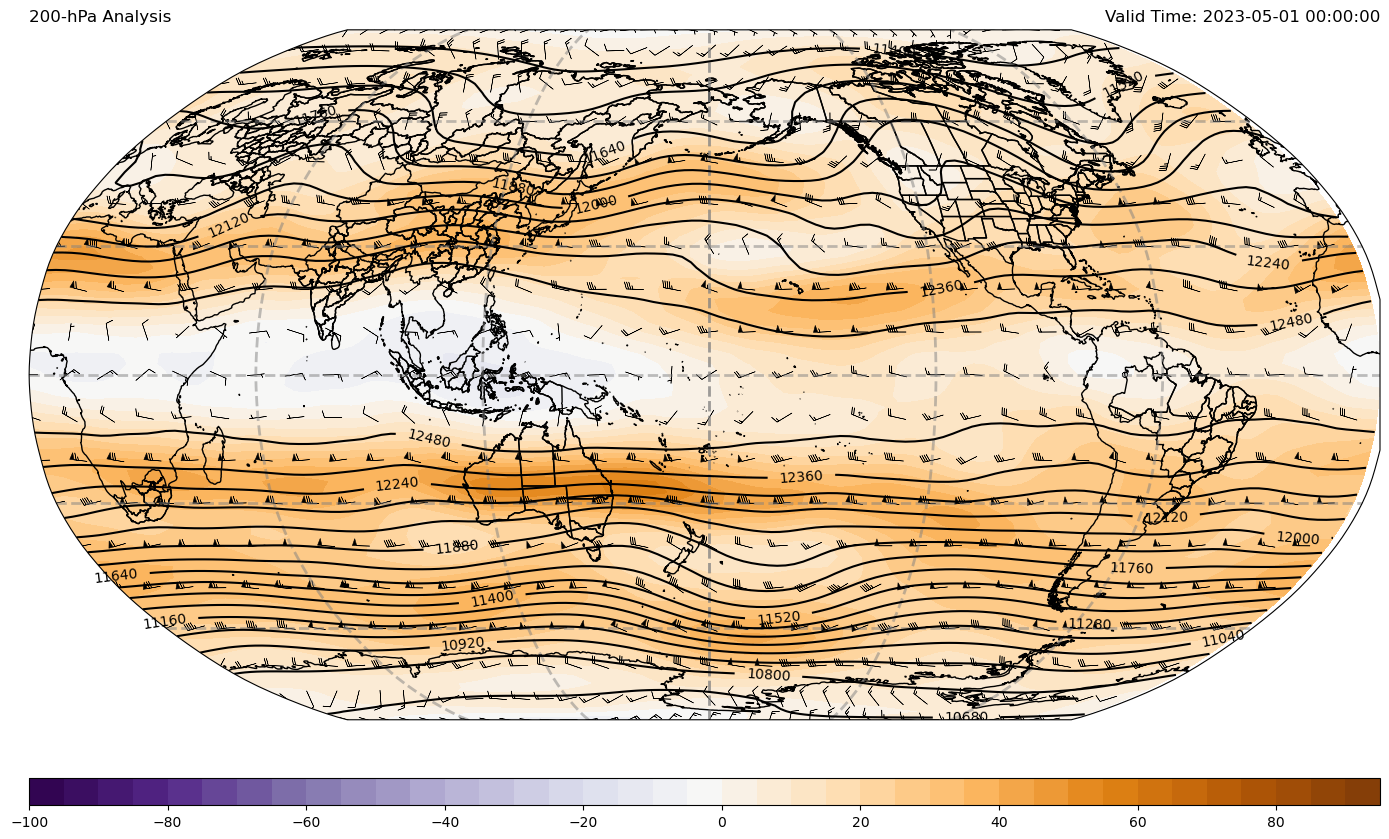

In [76]:

# Set up the projection that will be used for plotting
mapcrs = ccrs.Robinson(central_longitude=180)

# Set up the projection of the data; if lat/lon then PlateCarree is what you want
datacrs = ccrs.PlateCarree()

# Start the figure and create plot axes with proper projection
fig = plt.figure(1, figsize=(14, 12))
ax = plt.subplot(111, projection=mapcrs)

#not needed here, but used for sub-setting domain to plot
#ax.set_extent([-130, -72, 20, 55], ccrs.PlateCarree())

# Add geopolitical boundaries for map reference
ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
ax.add_feature(cfeature.STATES.with_scale('50m'))
gl = ax.gridlines(color='gray',linewidth=2, alpha = 0.5, linestyle='--')

# labels gridlines for PlateCarree ccrs option (doesn't work with Robinson, etc.)
#gl.xlabels_top = False
#gl.ylabels_right = False

#color-filled contour time!
#plotting temperature and including color bar
cf = ax.contourf(lons, lats, uwnd, clevs_uwnd, cmap=plt.cm.PuOr_r, transform=datacrs)
plt.colorbar(cf, orientation='horizontal', pad=0.05, aspect=50)

# Plot 200-hPa Geopotential Heights in meters
cs = ax.contour(lons, lats, hght, clevs_hght, colors='black', transform=datacrs)
plt.clabel(cs, fmt='%d')

# Plot 200-hPa wind barbs in knots, regrid to reduce number of barbs
ax.barbs(lons[::4], lats[::4], u_barbs.to('kt')[::4,::4].m, v_barbs.to('kt')[::4,::4].m, pivot='middle',
         color='black', transform=datacrs, length=5, linewidth=0.4)

# Make some nice titles for the plot (one right, one left)
plt.title('200-hPa Analysis', loc='left')
plt.title('Valid Time: {}'.format(vtime), loc='right')

# Reduce excessive white space around image and show
plt.tight_layout()
plt.savefig('200hPaAnalysis' + str(monthlabel) + str(year), dpi=150)
plt.show()